# Imports

In [11]:
import os
import logging
import typing as tp

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection.iterative_stratification import IterativeStratification

%matplotlib inline
os.chdir('Users/m.strahov/planet')

FileNotFoundError: [Errno 2] No such file or directory: 'Users/m.strahov/planet'

# Constants

In [13]:
CSV_PATH = 'data/train_v2.csv'
IMAGE_PATH = 'data/train-jpg'

# Main

## One-hoted df

In [40]:
df = pd.read_csv(CSV_PATH)
df['image_name'] = IMAGE_PATH + '/' + df['image_name'] + '.jpg'
df.tags = df.tags.apply(lambda x: set(x.split(' ')))
mlb = MultiLabelBinarizer()
encoded = pd.DataFrame(mlb.fit_transform(df.tags), columns=mlb.classes_)
encoded_df = pd.concat((df['image_name'], encoded), axis=1)
encoded_df.to_csv('data/one-hot.csv', index=False)

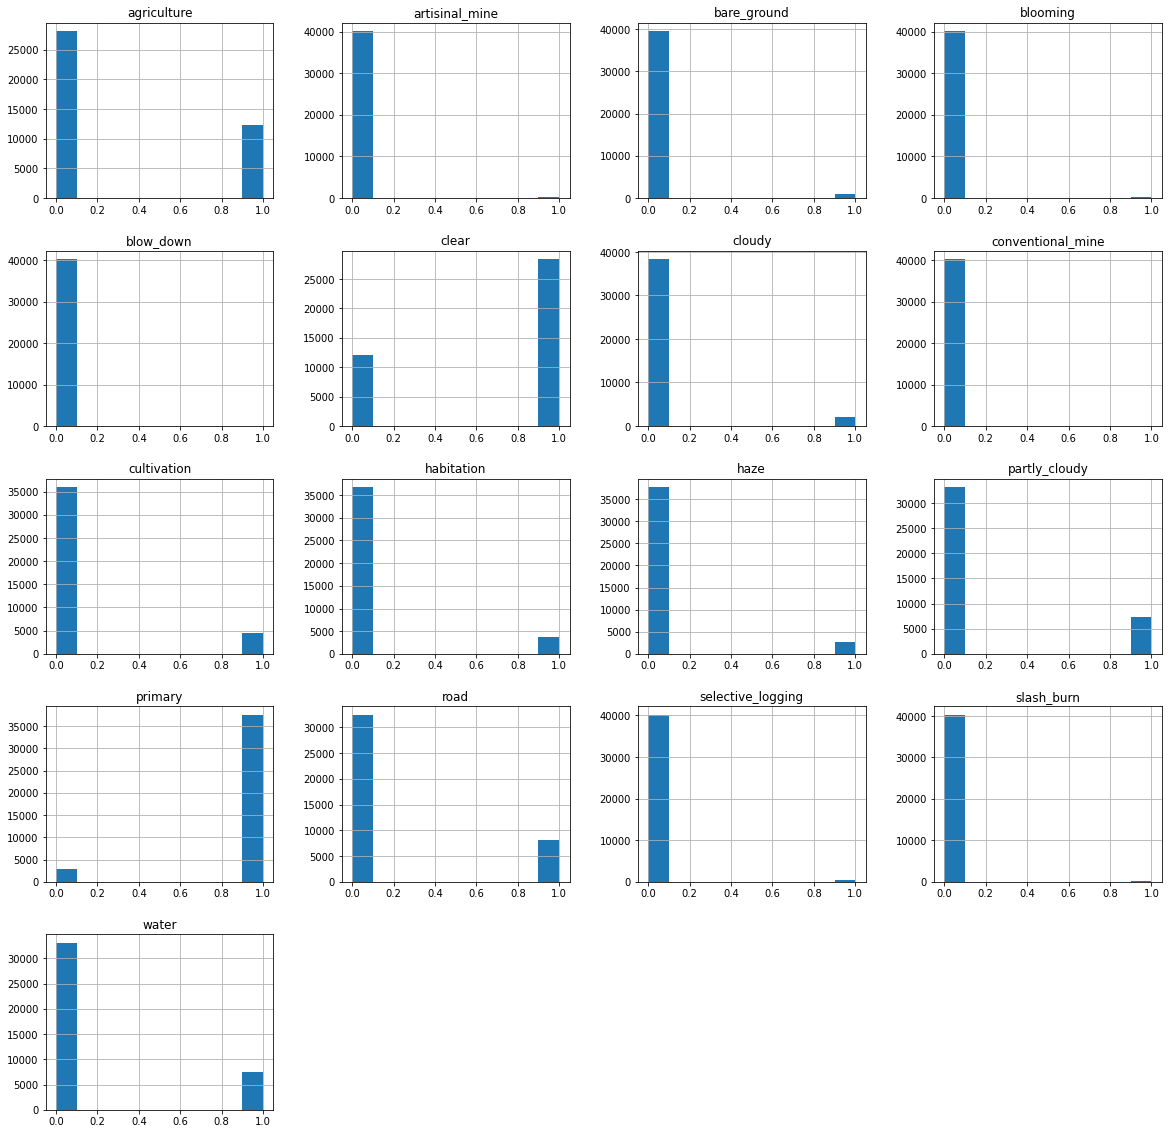

In [15]:
encoded_df.hist(figsize=(20, 20));

In [16]:
encoded_df.drop('image_name', axis=1).sum()

agriculture          12315
artisinal_mine         339
bare_ground            862
blooming               332
blow_down               98
clear                28431
cloudy                2089
conventional_mine      100
cultivation           4477
habitation            3660
haze                  2697
partly_cloudy         7261
primary              37513
road                  8071
selective_logging      340
slash_burn             209
water                 7411
dtype: int64

Code in next cell was kindly borrowed from you, guys :)

In [17]:
def _split(
    img_urls: np.array,
    labels: np.array,
    sample_distribution_per_fold: tp.Union[None, tp.List[float]] = None,
) -> tp.Tuple[np.array, np.array]:
    stratifier = IterativeStratification(
        n_splits=2, order=2, sample_distribution_per_fold=sample_distribution_per_fold
    )
    # this class is a generator that produces k-folds. we just want to iterate it once to make a single static split
    train_indexes, everything_else_indexes = next(
        stratifier.split(X=img_urls, y=labels)
    )

    num_overlapping_samples = len(set(train_indexes).intersection(set(everything_else_indexes)))
    if num_overlapping_samples != 0:
        raise ValueError(f'First splitting failed, {num_overlapping_samples} overlapping samples detected')

    return train_indexes, everything_else_indexes


def _show_split(  # noqa: WPS210
    train_fraction: float,
    y_train: np.array,
    y_dev: np.array,
    y_val: np.array,
    full_dataset: pd.DataFrame,
) -> tp.NoReturn:
    val_test_fraction = (1.0 - train_fraction) / 2
    info = [('train', train_fraction, y_train), ('test', val_test_fraction, y_dev), ('val', val_test_fraction, y_val)]

    for subset_name, frac, encodings_collection in info:
        # column-wise sum. sum(counts) > n_samples due to imgs with >1 class
        count_values = np.sum(encodings_collection, axis=0)
        # skip first col, which is the image key, not a class ID
        counts = {class_id: count_val for class_id, count_val in zip(full_dataset.columns[1:], count_values)}
        logging.info(f' {subset_name} subset ({frac * 100:.1f}%) encodings counts after stratification: {counts}')


def stratify_shuffle_split_subsets(  # noqa: WPS210
    full_dataset: pd.DataFrame,
    img_path_column: str = 'Id',
    train_fraction: float = 0.8,
    verbose: bool = False,
) -> tp.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Stratify-shuffle-split a multi-class multi-label dataset into train/validation/test sets.

    Source code got from here:
    https://www.richarddecal.com/2020-11-22-Howto-stratified-splitting-Multiclass-Multilabeled-image-classification-dataset/

    :param full_dataset: the full supervised dataset. One column is the img uris, and the rest are binary labels.
    :param img_path_column: the name of the img path column.
    :param train_fraction: the fraction of data to reserve for the training dataset. The remaining data will be evenly
        split into the dev and validation subsets.
    :param verbose: print info about process or not.
    :return: train/validation/test subsets.
    """
    # pandas documentation says to use .to_numpy() instead of .values for consistency
    img_urls = full_dataset[img_path_column].to_numpy()

    # sanity check: no duplicate labels
    if len(img_urls) != len(set(img_urls)):
        raise ValueError('Duplicate image keys detected.')

    labels = full_dataset.drop(columns=[img_path_column]).to_numpy().astype(int)
    # NOTE generators are replicated across workers. do stratified shuffle split beforehand
    logging.info('Stratifying dataset iteratively. this may take a while.')
    # NOTE: splits >2 broken; https://github.com/scikit-multilearn/scikit-multilearn/issues/209
    # so, do 2 rounds of iterative splitting
    train_indexes, everything_else_indexes = _split(img_urls, labels, [1.0 - train_fraction, train_fraction])
    x_train, x_else = img_urls[train_indexes], img_urls[everything_else_indexes]
    y_train, y_else = labels[train_indexes, :], labels[everything_else_indexes, :]

    dev_indexes, val_indexes = _split(x_else, y_else)
    x_dev, x_val = x_else[dev_indexes], x_else[val_indexes]
    y_dev, y_val = y_else[dev_indexes, :], y_else[val_indexes, :]

    if verbose:
        _show_split(train_fraction, y_train, y_dev, y_val, full_dataset)

    # combine (x,y) data into dataframes
    train_subset = pd.DataFrame(y_train)
    train_subset.insert(0, img_path_column, pd.Series(x_train))
    train_subset.columns = full_dataset.columns

    dev_subset = pd.DataFrame(y_dev)
    dev_subset.insert(0, img_path_column, pd.Series(x_dev))
    dev_subset.columns = full_dataset.columns

    val_subset = pd.DataFrame(y_val)
    val_subset.insert(0, img_path_column, pd.Series(x_val))
    val_subset.columns = full_dataset.columns

    logging.info('Stratifying dataset is completed.')

    return train_subset, val_subset, dev_subset


In [41]:
train_df, valid_df, test_df = stratify_shuffle_split_subsets(
    encoded_df,
    img_path_column='image_name',
    train_fraction=0.8,
    verbose=False
)

In [42]:
len(train_df), len(valid_df), len(test_df)

(32341, 4074, 4064)

In [43]:
len(encoded_df)

40479

In [44]:
train_df.to_csv('data/train_df.csv', index=False)
valid_df.to_csv('data/valid_df.csv', index=False)
test_df.to_csv('data/test_df.csv', index=False)

In [24]:
import shutil

In [45]:
df_for_tests = None
for df in (train_df.copy(), test_df.copy(), valid_df.copy()):
    samples = df.iloc[:5]
    for index, row in samples.iterrows():
        image_path = row['image_name']
        image_name = os.path.split(image_path)[-1]
        target_path = os.path.join('test_data', image_name)
        print(image_path)
        print(target_path)
        shutil.copy(image_path, target_path)
    samples['image_name'] = samples['image_name'].apply(
        lambda path: os.path.join('test_data', os.path.split(path)[-1])
    )
    if df_for_tests is None:
        df_for_tests = samples
    else:
        df_for_tests = pd.concat((df_for_tests, samples))
df_for_tests.to_csv('test_data/data.csv', index=False)


data/train-jpg/train_3.jpg
test_data/train_3.jpg
data/train-jpg/train_4.jpg
test_data/train_4.jpg
data/train-jpg/train_5.jpg
test_data/train_5.jpg
data/train-jpg/train_8.jpg
test_data/train_8.jpg
data/train-jpg/train_10.jpg
test_data/train_10.jpg


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


data/train-jpg/train_0.jpg
test_data/train_0.jpg
data/train-jpg/train_2.jpg
test_data/train_2.jpg
data/train-jpg/train_6.jpg
test_data/train_6.jpg
data/train-jpg/train_9.jpg
test_data/train_9.jpg
data/train-jpg/train_18.jpg
test_data/train_18.jpg
data/train-jpg/train_1.jpg
test_data/train_1.jpg
data/train-jpg/train_7.jpg
test_data/train_7.jpg
data/train-jpg/train_11.jpg
test_data/train_11.jpg
data/train-jpg/train_12.jpg
test_data/train_12.jpg
data/train-jpg/train_15.jpg
test_data/train_15.jpg


In [37]:
os.path.exists('test_data')

True